In [120]:
# Data handling
import numpy as np
import pandas as pd
import re

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import graphviz
import optuna
import optuna.visualization as vis
%matplotlib inline

# Stats
from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm
import scipy.stats as st
from scipy.stats import shapiro, norm, chi2_contingency, kstest, boxcox

# Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder,PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance

# Models
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.tree import export_graphviz, DecisionTreeClassifier

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Metrics
from sklearn.metrics import  accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix, classification_report #Classifier
from sklearn.inspection import permutation_importance

#lib

#
from typing import Any, Optional

# os
import os

import pickle

# time
import time

import warnings
# warnings.filterwarnings("ignore")    # (Optional)

print("Project has been created with Pandas: " ,pd. __version__," And with Numpy: ",np. __version__)

Project has been created with Pandas:  2.2.3  And with Numpy:  1.26.4


### Loading

In [121]:
import yaml

try:
    with open("../config.yaml", "r") as file:
        config = yaml.safe_load(file)
except:
    print("Yaml configuration file not found!")

In [122]:
config

{'data': {'raw': {'file_scraped': '../data/raw/vscode_extensions_scraped_0825.csv',
   'file_verified': '../data/raw/VSCode Extensions_Verified.csv',
   'file_vulnerable': '../data/raw/VSCode Extensions_Vulnerabilities.csv',
   'file_ext_repo': '../data/raw/extensions_repos_full.csv'},
  'clean': {'file_scrap_cleaned': '../data/clean/extensions_scrap_cleaned.csv',
   'file_data_cleaned': '../data/clean/extensions_data_cleaned.csv',
   'file_eda_cleaned': '../data/clean/extensions_eda_cleaned.csv'}},
 'model': {'base_path': '../models/',
  'training_path': '../models/train/',
  'preprocessing_path': '../models/preprocess/',
  'preprocessing': {'file_ohe': '../models/one_hot_encoder.pkl'}}}

In [123]:
# df = pd.read_csv("./extensions_eda_cleaned.csv")
df = pd.read_csv(config["data"]["clean"]["file_eda_cleaned"])
df.head()

,ext_categories,ext_install_count,verified,total_vulners,high_vulners,medium_vulners,low_vulners,repo_stars,repo_forks,repo_languages,ext_rating_category,ext_version_category
0,Programming Languages,28923,True,0,0,0,0,44,10,typescript,2,2
1,Programming Languages,28923,True,0,0,0,0,44,10,python,2,2
2,Programming Languages,28923,True,0,0,0,0,44,10,javascript,2,2
3,Programming Languages,28923,True,0,0,0,0,44,10,jupyter notebook,2,2
4,Programming Languages,28923,True,0,0,0,0,4461,10,shell,2,2


### 5. Preprocessing

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37929 entries, 0 to 37928
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ext_categories        37929 non-null  object
 1   ext_install_count     37929 non-null  int64 
 2   verified              37929 non-null  bool  
 3   total_vulners         37929 non-null  int64 
 4   high_vulners          37929 non-null  int64 
 5   medium_vulners        37929 non-null  int64 
 6   low_vulners           37929 non-null  int64 
 7   repo_stars            37929 non-null  int64 
 8   repo_forks            37929 non-null  int64 
 9   repo_languages        37929 non-null  object
 10  ext_rating_category   37929 non-null  int64 
 11  ext_version_category  37929 non-null  int64 
dtypes: bool(1), int64(9), object(2)
memory usage: 3.2+ MB


- Handle duplicated

In [125]:
df.duplicated().sum()

932

In [126]:
df = df.drop_duplicates()
df

,ext_categories,ext_install_count,verified,total_vulners,high_vulners,medium_vulners,low_vulners,repo_stars,repo_forks,repo_languages,ext_rating_category,ext_version_category
0,Programming Languages,28923,True,0,0,0,0,44,10,typescript,2,2
1,Programming Languages,28923,True,0,0,0,0,44,10,python,2,2
2,Programming Languages,28923,True,0,0,0,0,44,10,javascript,2,2
3,Programming Languages,28923,True,0,0,0,0,44,10,jupyter notebook,2,2
4,Programming Languages,28923,True,0,0,0,0,4461,10,shell,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...
37924,Other,3,False,0,0,0,0,42,6,javascript,0,0
37925,Other,3,False,0,0,0,0,42,6,shell,0,0
37926,Other,2,False,0,0,0,0,1,1,typescript,0,1
37927,Other,1,True,1,1,0,0,3,0,typescript,0,1


- Handle missing values

In [127]:
df.isna().sum()

ext_categories          0
ext_install_count       0
verified                0
total_vulners           0
high_vulners            0
medium_vulners          0
low_vulners             0
repo_stars              0
repo_forks              0
repo_languages          0
ext_rating_category     0
ext_version_category    0
dtype: int64

- Feature transformation/Transform values

Handle categories with high cardinality -> Grouping/Binning

In [128]:
df["ext_categories"].value_counts(normalize=True)

ext_categories
Other                    0.354083
Programming Languages    0.184285
Themes                   0.132984
Snippets                 0.110658
Formatters               0.047788
Linters                  0.038219
Debuggers                0.032057
Extension Packs          0.022407
Visualization            0.019975
Testing                  0.010568
Data Science             0.007676
Education                0.006568
Machine Learning         0.006298
Keymaps                  0.006136
Notebooks                0.005136
Azure                    0.004811
Language Packs           0.004757
SCM Providers            0.004135
AI                       0.000838
Chat                     0.000622
Name: proportion, dtype: float64

In [129]:
df["repo_languages"].value_counts(normalize=True)

repo_languages
typescript                  0.312971
javascript                  0.219775
unknown                     0.167851
css                         0.046544
html                        0.038652
                              ...   
zenscript                   0.000027
isabelle                    0.000027
module management system    0.000027
rexx                        0.000027
qt script                   0.000027
Name: proportion, Length: 266, dtype: float64

In [130]:
threshold_ext_categories = 0.1  # e.g., categories below 10% frequency
value_counts_ext_categories = df["ext_categories"].value_counts(normalize=True)
rare_categories = value_counts_ext_categories[value_counts_ext_categories.values <= threshold_ext_categories].index

def transform_ext_categories(x):
    text = str(x)
    if text == "Other":
        return "Unknown"
    elif text in rare_categories:
        return "Others"
    else:
        return x
df["ext_categories_grouped"] = df["ext_categories"].apply(transform_ext_categories)

In [131]:
threshold_repo_languages = 0.05 # e.g., categories below 5% frequency
value_counts_repo_languages = df["repo_languages"].value_counts(normalize=True)
rare_categories = value_counts_repo_languages[value_counts_repo_languages.values <= threshold_repo_languages].index

def transform_repo_languages(x):
    text = str(x)
    if text  in ["other", "unknown"]:
        return "unknown"
    elif text in rare_categories:
        return "others"
    else:
        return x
df["repo_languages_grouped"] = df["repo_languages"].apply(transform_repo_languages)

In [132]:
# threshold_ext_categories = 0.1  # e.g., categories below 10% frequency
# value_counts_ext_categories = df['ext_categories'].value_counts(normalize=True)
# rare_categories = value_counts_ext_categories[value_counts_ext_categories.values <= threshold_ext_categories].index
# df['ext_categories_grouped'] = df['ext_categories'].apply(lambda x: 'Rest' if x in rare_categories else x)


In [133]:
# threshold_repo_languages = 0.03  # e.g., categories below 3% frequency
# value_counts_repo_languages = df["repo_languages"].value_counts(normalize=True)
# rare_categories = value_counts_repo_languages[value_counts_repo_languages.values <= threshold_repo_languages].index
# df["repo_languages_grouped"] = df["repo_languages"].apply(lambda x: 'rest' if x in rare_categories else x)

In [134]:
df["ext_categories_grouped"].value_counts(normalize=True)

ext_categories_grouped
Unknown                  0.354083
Others                   0.217991
Programming Languages    0.184285
Themes                   0.132984
Snippets                 0.110658
Name: proportion, dtype: float64

In [135]:
df["repo_languages_grouped"].value_counts(normalize=True)

repo_languages_grouped
typescript    0.312971
others        0.269265
javascript    0.219775
unknown       0.197989
Name: proportion, dtype: float64

In [136]:
df = df.drop(columns=["repo_languages", "ext_categories"])
df

,ext_install_count,verified,total_vulners,high_vulners,medium_vulners,low_vulners,repo_stars,repo_forks,ext_rating_category,ext_version_category,ext_categories_grouped,repo_languages_grouped
0,28923,True,0,0,0,0,44,10,2,2,Programming Languages,typescript
1,28923,True,0,0,0,0,44,10,2,2,Programming Languages,others
2,28923,True,0,0,0,0,44,10,2,2,Programming Languages,javascript
3,28923,True,0,0,0,0,44,10,2,2,Programming Languages,others
4,28923,True,0,0,0,0,4461,10,2,2,Programming Languages,others
...,...,...,...,...,...,...,...,...,...,...,...,...
37924,3,False,0,0,0,0,42,6,0,0,Unknown,javascript
37925,3,False,0,0,0,0,42,6,0,0,Unknown,others
37926,2,False,0,0,0,0,1,1,0,1,Unknown,typescript
37927,1,True,1,1,0,0,3,0,0,1,Unknown,typescript


- Convert target to number

In [137]:
df["verified"] = df["verified"].map({True: 1, False:0})

- Get number and category columns

In [138]:
potential_categorical_from_numerical = df.select_dtypes("number").loc[:, df.select_dtypes("number").nunique() < 10].drop(columns="verified")
potential_categorical_from_numerical

,ext_rating_category,ext_version_category
0,2,2
1,2,2
2,2,2
3,2,2
4,2,2
...,...,...
37924,0,0
37925,0,0
37926,0,1
37927,0,1


In [139]:

df_categorical = pd.concat([df.select_dtypes("object"), potential_categorical_from_numerical], axis=1)
df_numerical = df.select_dtypes("number").drop(columns=potential_categorical_from_numerical.columns)

In [140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36997 entries, 0 to 37928
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ext_install_count       36997 non-null  int64 
 1   verified                36997 non-null  int64 
 2   total_vulners           36997 non-null  int64 
 3   high_vulners            36997 non-null  int64 
 4   medium_vulners          36997 non-null  int64 
 5   low_vulners             36997 non-null  int64 
 6   repo_stars              36997 non-null  int64 
 7   repo_forks              36997 non-null  int64 
 8   ext_rating_category     36997 non-null  int64 
 9   ext_version_category    36997 non-null  int64 
 10  ext_categories_grouped  36997 non-null  object
 11  repo_languages_grouped  36997 non-null  object
dtypes: int64(10), object(2)
memory usage: 3.7+ MB


In [141]:
cols_num = df_numerical.columns.to_list()

In [142]:
cols_num = df_numerical.drop(["verified","total_vulners"],axis=1).columns.to_list() #Drop 'total_vulners'
# cols_num = df_numerical.drop(["verified","total_vulners","repo_stars"],axis=1).columns.to_list() #Drop 'total_vulners'
cols_cat = df_categorical.columns.to_list()
cols_num, cols_cat

(['ext_install_count',
  'high_vulners',
  'medium_vulners',
  'low_vulners',
  'repo_stars',
  'repo_forks'],
 ['ext_categories_grouped',
  'repo_languages_grouped',
  'ext_rating_category',
  'ext_version_category'])

In [143]:
df_corr = pd.concat([df[cols_num], df["verified"]], axis=1)

Correlation of features & target

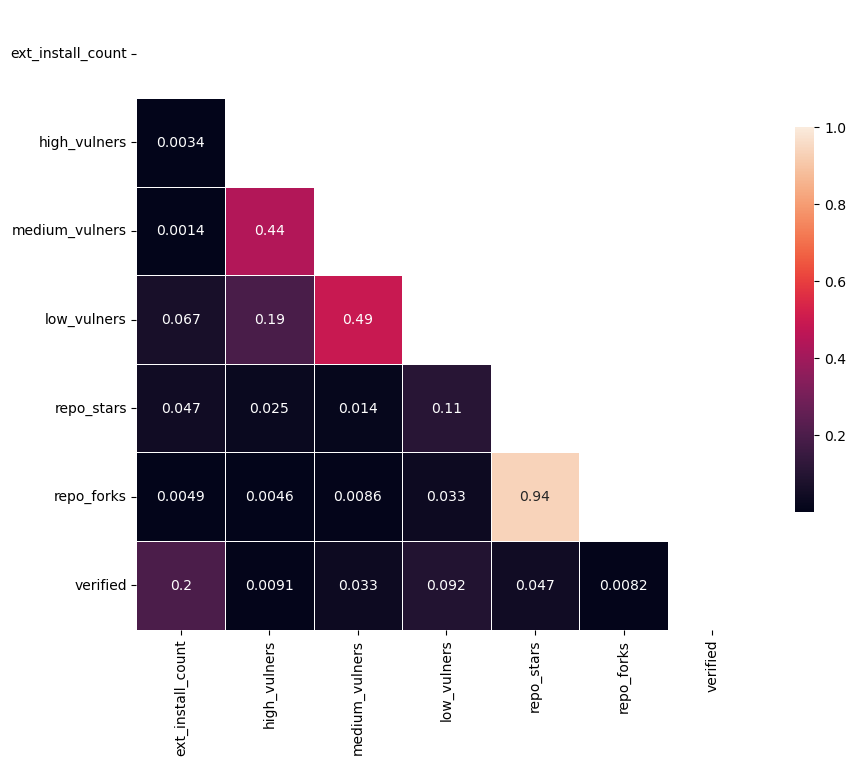

In [144]:

# corr=np.abs(X_train_trans.corr(method="pearson"))
corr=np.abs(df_corr.corr(method="pearson"))

# Set up mask for triangle representation
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(corr, vmax=1,square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = corr)
sns.heatmap(corr, mask=mask,  vmax=1,square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = corr)

plt.show()

#### Spliting Test data

In [145]:
features = df.drop(columns = ["verified","total_vulners"])
# features = df.drop(["verified","total_vulners","repo_stars"], axis = 1)
target = df["verified"]
X_train, X_test, y_train, y_test = train_test_split(features,target, test_size = 0.20, random_state=0) #before transforming

In [146]:
X_train.shape, X_test.shape

((29597, 10), (7400, 10))

In [147]:
df

,ext_install_count,verified,total_vulners,high_vulners,medium_vulners,low_vulners,repo_stars,repo_forks,ext_rating_category,ext_version_category,ext_categories_grouped,repo_languages_grouped
0,28923,1,0,0,0,0,44,10,2,2,Programming Languages,typescript
1,28923,1,0,0,0,0,44,10,2,2,Programming Languages,others
2,28923,1,0,0,0,0,44,10,2,2,Programming Languages,javascript
3,28923,1,0,0,0,0,44,10,2,2,Programming Languages,others
4,28923,1,0,0,0,0,4461,10,2,2,Programming Languages,others
...,...,...,...,...,...,...,...,...,...,...,...,...
37924,3,0,0,0,0,0,42,6,0,0,Unknown,javascript
37925,3,0,0,0,0,0,42,6,0,0,Unknown,others
37926,2,0,0,0,0,0,1,1,0,1,Unknown,typescript
37927,1,1,1,1,0,0,3,0,0,1,Unknown,typescript


### Feature Engineering

OHE: for nominal categorial

In [148]:
ohe = OneHotEncoder(sparse_output=False)
ohe.fit((X_train[["repo_languages_grouped", "ext_categories_grouped"]]))
X_train_trans_nom_np = ohe.transform(X_train[["repo_languages_grouped", "ext_categories_grouped"]])
X_test_trans_nom_np = ohe.transform(X_test[["repo_languages_grouped", "ext_categories_grouped"]])

X_train_nom_trans_df = pd.DataFrame(X_train_trans_nom_np, columns=ohe.get_feature_names_out(), index=X_train.index)
X_test_nom_trans_df = pd.DataFrame(X_test_trans_nom_np, columns=ohe.get_feature_names_out(), index=X_test.index)

In [149]:
X_train_nom_trans_df

,repo_languages_grouped_javascript,repo_languages_grouped_others,repo_languages_grouped_typescript,repo_languages_grouped_unknown,ext_categories_grouped_Others,ext_categories_grouped_Programming Languages,ext_categories_grouped_Snippets,ext_categories_grouped_Themes,ext_categories_grouped_Unknown
27384,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2451,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1999,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6080,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8646,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
20887,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
32447,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
30666,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
21374,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [150]:
base_name = f"X_train_{id(X_train)}_Y_train_{id(y_train)}"
file_path = f"{config["model"]["preprocessing_path"]}{base_name}_onehot_encoding.pkl"

with open(file_path, "wb") as file:
    pickle.dump(ohe, file)

Ordinal columns aren't not transform due to grouped as number

Transform cols_num to normal distribution

In [151]:
fig, axes = plt.subplots(nrows = int(np.ceil(len(cols_num)/2)), ncols = 2, figsize = (8,10))
axes = axes.flat

for i,col in enumerate(cols_num):
    sm.qqplot(X_test[col],
           line = "s",
           ax = axes[i])

    axes[i].set_title(col, fontsize = 10, fontweight = "bold", color = "black")

# fig.delaxes(axes[7])
fig.suptitle("QQ-Plots before Transforming", fontsize = 12, fontweight = "bold", color = "darkblue")
fig.tight_layout()
fig.show()

C:\Users\Gast\AppData\Local\Temp\ipykernel_6704\751889851.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


- Powertransform

In [152]:
# Power transform
pt = PowerTransformer(method="yeo-johnson")

X_train_num = X_train[cols_num]
pt.fit(X_train_num)

X_test_num  = X_test[cols_num]

X_train_num_trans = pt.transform(X_train_num)
X_test_num_trans = pt.transform(X_test_num)

X_train_num_trans_df = pd.DataFrame(X_train_num_trans, columns=X_train_num.columns, index=X_train_num.index )
X_test_num_trans_df = pd.DataFrame(X_test_num_trans, columns=X_test_num.columns, index=X_test_num.index )

In [153]:
base_name = f"X_train_{id(X_train)}_Y_train_{id(y_train)}"
file_path = f"{config["model"]["preprocessing_path"]}{base_name}_power_transform.pkl"

with open(file_path, "wb") as file:
    pickle.dump(ohe, file)

- Normalize transform

In [154]:
# #Normalizer
# normalizer = MinMaxScaler()
# X_train_num = X_train[cols_num]
# normalizer.fit(X_train_num)
# X_test_num  = X_test[cols_num]

# X_train_trans = normalizer.transform(X_train_num)
# X_test_trans = normalizer.transform(X_test_num)

# X_train_trans = pd.DataFrame(X_train_trans, columns=X_train_num.columns, index=X_train_num.index)
# X_test_trans = pd.DataFrame(X_test_trans, columns=X_test_num.columns, index=X_test_num.index)

- Log Transform

In [155]:
# #Log-transform
# for col in cols_num:
#     df[col] = np.log1p(df[col])
    # X_train_trans = pt.transform(X_train_num)
    # X_test_trans = pt.transform(X_test_num)

In [156]:
fig, axes = plt.subplots(nrows = int(np.ceil(len(cols_num)/2)), ncols = 2, figsize = (8,10))
axes = axes.flat

for i,col in enumerate(cols_num):
    # sns.histplot(X_test_num_trans_df[col],
    #              kde=True,
    #              bins=20,
    #              color="orange",
    #              ax=axes[i])

    sm.qqplot(X_test_num_trans_df[col],
           line = "s",
           ax = axes[i]);

    axes[i].set_title(col, fontsize = 10, fontweight = "bold", color = "black")

# fig.delaxes(axes[7])
fig.suptitle("QQ-Plots after Transforming", fontsize = 12, fontweight = "bold", color = "darkblue")
fig.tight_layout()
fig.show()


C:\Users\Gast\AppData\Local\Temp\ipykernel_6704\1168897307.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Combining

In [157]:
X_train_ord_trans_df = X_train[["ext_rating_category","ext_version_category"]].copy()
X_test_ord_trans_df = X_test[["ext_rating_category","ext_version_category"]].copy()

In [158]:
X_train_trans = pd.concat([X_train_num_trans_df, X_train_nom_trans_df, X_train_ord_trans_df], axis=1)
X_test_trans = pd.concat([X_test_num_trans_df, X_test_nom_trans_df, X_test_ord_trans_df], axis=1)


In [159]:
X_trans =  pd.concat([X_train_trans, X_test_trans], axis = 0)
y_trans = pd.concat([y_train, y_test], axis = 0)

In [160]:
df_trans = pd.concat([X_trans,y_trans], axis = 1)
df_trans

,ext_install_count,high_vulners,medium_vulners,low_vulners,repo_stars,repo_forks,repo_languages_grouped_javascript,repo_languages_grouped_others,repo_languages_grouped_typescript,repo_languages_grouped_unknown,ext_categories_grouped_Others,ext_categories_grouped_Programming Languages,ext_categories_grouped_Snippets,ext_categories_grouped_Themes,ext_categories_grouped_Unknown,ext_rating_category,ext_version_category,verified
27384,-0.695243,-0.194514,-0.340805,-0.388464,-1.321648,-0.997503,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1,0
2451,2.139363,-0.194514,2.909899,-0.388464,1.541664,1.828620,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2,2,1
1999,1.201850,-0.194514,-0.340805,-0.388464,0.501185,0.909553,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1,0
6080,1.239527,-0.194514,-0.340805,-0.388464,-1.321648,0.788727,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,1,0
8646,0.858604,5.141013,2.909899,-0.388464,1.100528,1.307979,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35386,-1.545754,-0.194514,-0.340805,-0.388464,-0.336210,-0.036693,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,1,0
21109,-0.215489,-0.194514,-0.340805,-0.388464,0.029337,-0.036693,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2,0,0
28576,-0.781584,-0.194514,-0.340805,-0.388464,-1.321648,-0.036693,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0
9126,0.802428,-0.194514,-0.340805,-0.388464,0.588600,-0.997503,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2,1,0


In [161]:
# X_train_trans.shape[0] == X_train.shape[0]
# X_test_trans.shape[0] == X_test.shape[0]

In [162]:
# X_train_corr = pd.concat([X_train_trans, y_train], axis=1)

Feature Selection

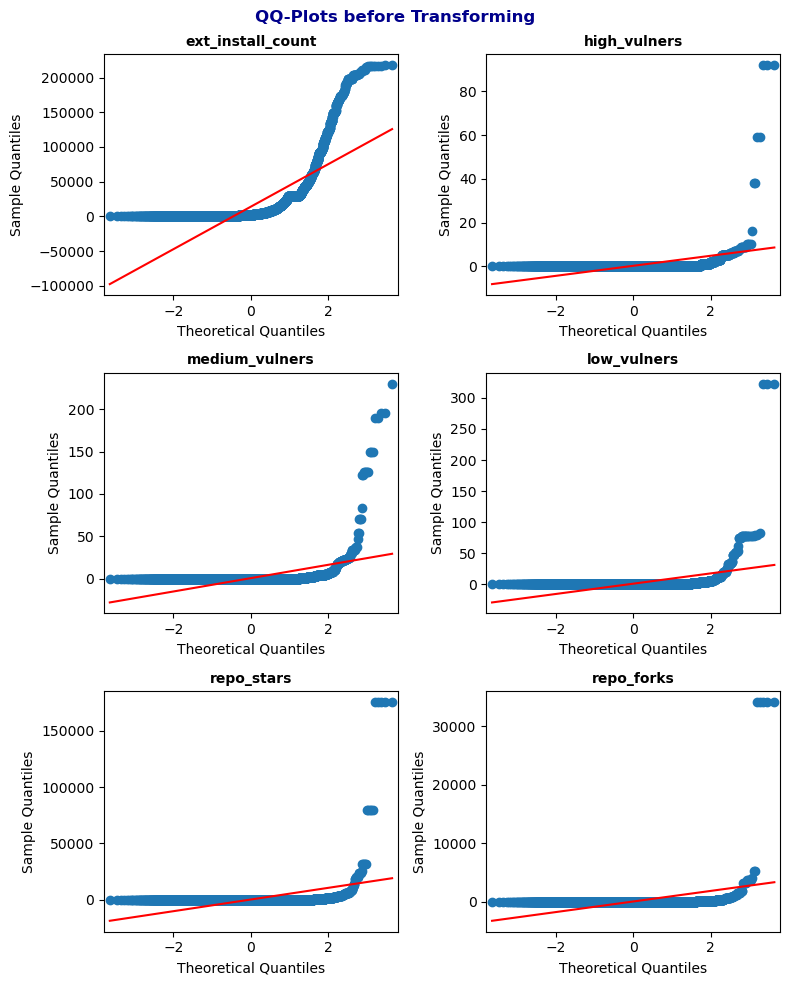

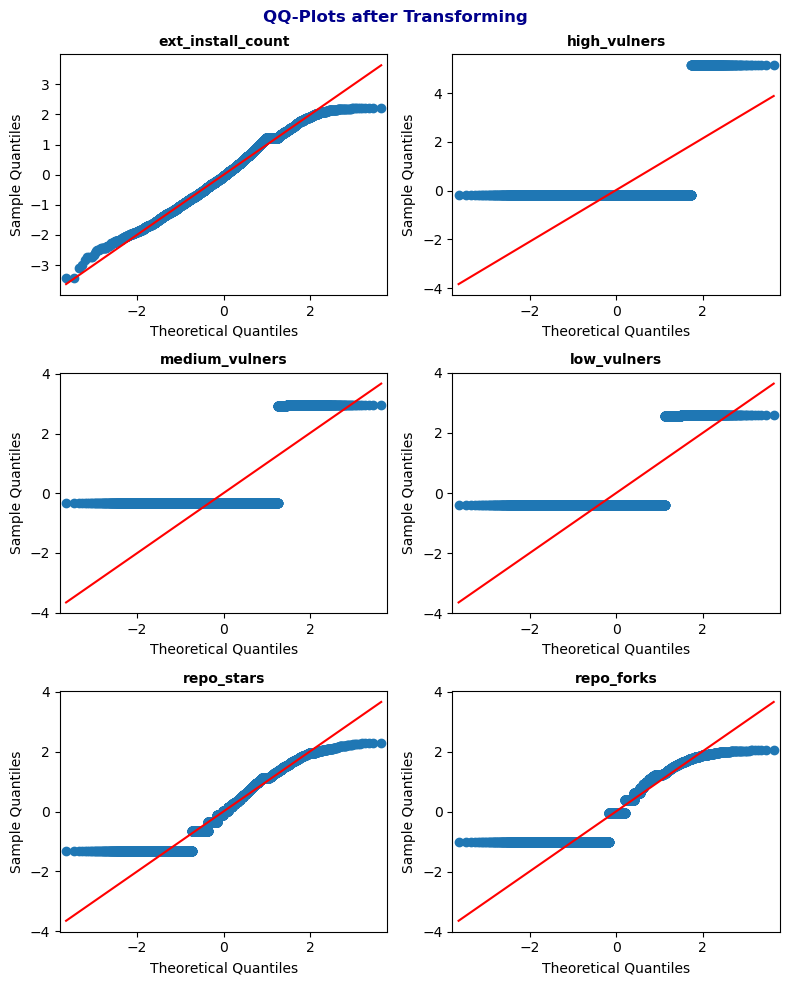

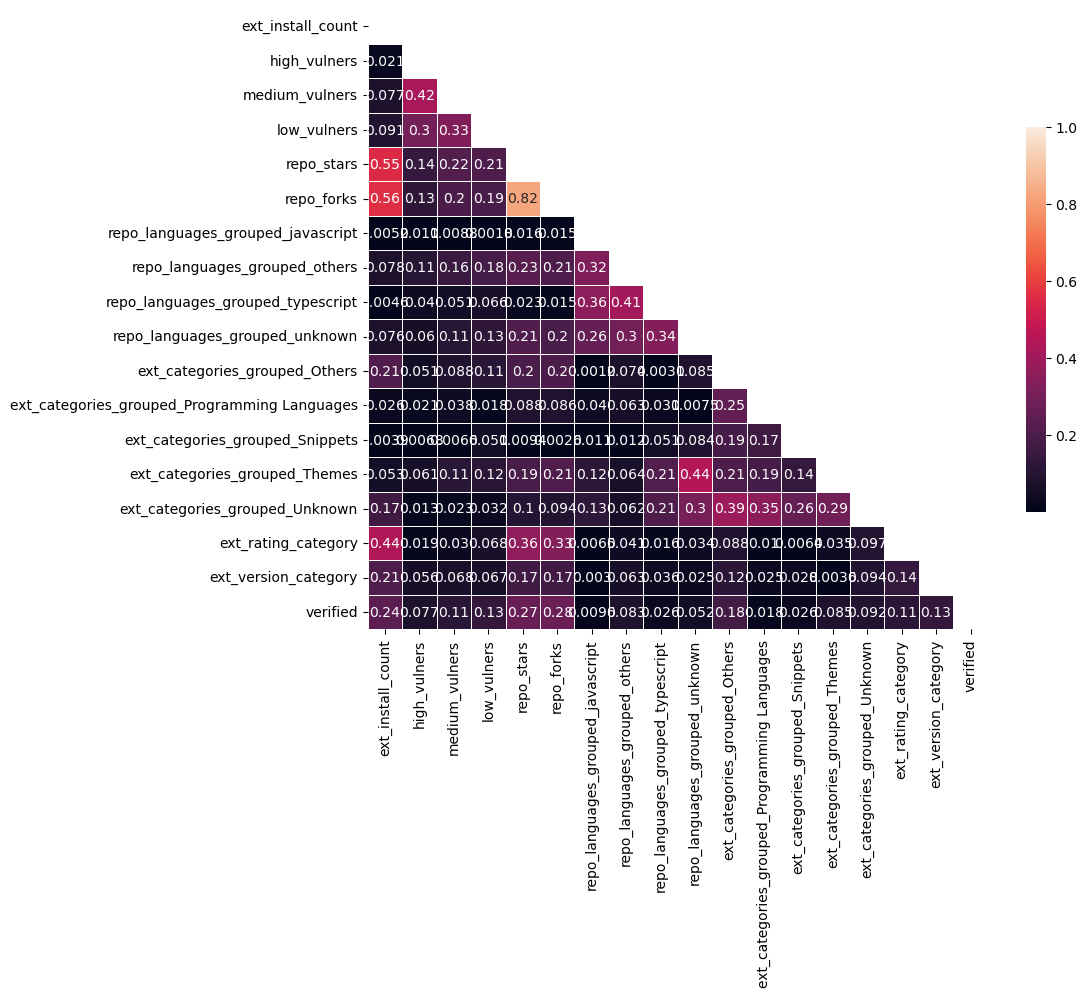

In [163]:
# corr=np.abs(X_train_trans.corr(method="pearson"))
corr=np.abs(df_trans.corr(method="pearson"))

# Set up mask for triangle representation
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(corr, vmax=1,square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = corr)
sns.heatmap(corr, mask=mask,  vmax=1,square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = corr)

plt.show()

**_We want low correlation between features, but high correlation between features and our target._**

There are high correlations between **_repo stars vs repo forks

In [164]:
# df_trans= df_trans.drop("total_vulners",axis=1)

Split again the test data

In [165]:
# features_ = df_trans.drop(columns = ["verified"])
# target_ = df_trans["verified"]
# Xtrans_train, Xtrans_test, ytrans_train, ytrans_test = train_test_split(features,target, test_size = 0.20, random_state=0)

#### Imbalanced

In [166]:
smote = SMOTE(random_state = 1,sampling_strategy=1.0)

In [167]:
X_train_smote, y_train_smote = smote.fit_resample(X_train_trans, y_train)

In [168]:
X_train_smote

,ext_install_count,high_vulners,medium_vulners,low_vulners,repo_stars,repo_forks,repo_languages_grouped_javascript,repo_languages_grouped_others,repo_languages_grouped_typescript,repo_languages_grouped_unknown,ext_categories_grouped_Others,ext_categories_grouped_Programming Languages,ext_categories_grouped_Snippets,ext_categories_grouped_Themes,ext_categories_grouped_Unknown,ext_rating_category,ext_version_category
0,-0.695243,-0.194514,-0.340805,-0.388464,-1.321648,-0.997503,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1
1,2.139363,-0.194514,2.909899,-0.388464,1.541664,1.828620,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2,2
2,1.201850,-0.194514,-0.340805,-0.388464,0.501185,0.909553,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1
3,1.239527,-0.194514,-0.340805,-0.388464,-1.321648,0.788727,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,1
4,0.858604,5.141013,2.909899,-0.388464,1.100528,1.307979,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53185,0.988532,-0.194514,-0.340805,2.575313,1.688118,1.847063,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2,2
53186,-1.063803,-0.194514,-0.340805,-0.388464,-1.321648,-0.997503,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
53187,2.155401,-0.194514,-0.340805,-0.388464,1.971428,1.913394,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2,1
53188,1.946691,-0.194514,-0.340805,-0.388464,0.547220,0.788727,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2,1


|Metric|Definition|	Meaning in Attrition Context|
| ----------- | ----------- | ----------- |
| Recall|  TP/(TP+FN) | 	Most important – how many true leavers you can catch|
| Precision	 |TP/(TP+FP) |	Among predicted leavers, how many are actually correct
Accuracy |(TP+TN)/Total |	Can be misleading with imbalanced data (e.g., <20% attrition) |
| F1-score |2⋅Precision⋅Recall/(Precision+Recall) |Balanced trade-off between Precision and Recall|
| AUC-ROC	|Area under ROC Curve |	Measures ability to distinguish leavers vs. stayers at all thresholds|

### ML-Training/Evaluation

In [169]:

def get_feature_importance(
    model: Any,
    x_test:  pd.DataFrame | np.ndarray,
    y_test:  pd.DataFrame | np.ndarray,
    method: str = "auto",
    feature_names: Optional[list] = None,
    top_n: int = 8,
    plot: bool = True,
    figsize: tuple = (6, 4),
    random_state: int = 0
) -> pd.DataFrame:
    # Determine method automatically if 'auto'
    if method == "auto":
        if hasattr(model, "feature_importances_"):
            method = "builtin"
        elif hasattr(model, "coef_"):
            method = "coefficients"
        else:
            method = "permutation"

    importance_scores = None
    importance_std = None
    method_name = ""
    sort_column = "" # Define a variable to store the column to sort by

    # Calculate importance based on method
    if method == "builtin":
        # Tree-based models (RandomForest, XGBoost, LightGBM, etc.)
        importance_scores = model.feature_importances_
        method_name = "Built-in Feature Importance"
        sort_column = "importance"

    elif method == "coefficients":
        # Linear models (LogisticRegression, LinearRegression, etc.)
        coef = model.coef_
        if coef.ndim > 1:
            # Multi-class classification - take mean of absolute values
            importance_scores = np.mean(np.abs(coef), axis=0)
        else:
            importance_scores = np.abs(coef)
            
        method_name = "Coefficient-based Importance"
        sort_column = "importance"

    elif method == "permutation":
        # Permutation importance - works with any model
        perm_importance = permutation_importance(
            model, x_test, y_test,
            n_repeats=5,  # Reduced for faster processing
            random_state=random_state,
            n_jobs=-1
        )
        importance_scores = perm_importance.importances_mean
        importance_std = perm_importance.importances_std
        method_name = "Permutation Importance"
        sort_column = "permutation"

    else:
        raise ValueError(f"Unknown method: {method}. Use 'auto', 'builtin', 'permutation', or 'coefficients'")

    feature_names = x_test.columns.tolist() if feature_names is None else feature_names

    # Create results DataFrame
    results_data = {
        "feature": feature_names,
        "importance": importance_scores
    }

    if importance_std is not None:
        results_data["importance_std"] = importance_std
        # If permutation importance was calculated, the importance column is named 'permutation'
        if method == "permutation":
             results_data["permutation"] = importance_scores
             results_data.pop("importance") # Remove the 'importance' column

    importance_df = pd.DataFrame(results_data).sort_values(sort_column, ascending=False) # Sort by the determined column
    model_name = type(model).__name__

    # Create visualization
    if plot:
        plt.figure(figsize=figsize)

        # Get top N features
        top_features = importance_df.head(top_n)
        ax = sns.barplot(
            data=top_features,
            x=sort_column, # Use the determined column name for the x-axis
            y="feature",
            hue="feature",
            # alpha=0.8,
            legend=False)

        # Customize plot
        ax.set_xlabel("Importance Score", fontsize=10)
        ax.set_ylabel("Features", fontsize=10)
        ax.set_title(f"{model_name} - {method_name} - Top {min(top_n, len(top_features))} Features",
                     fontsize=10, fontweight="bold")
        plt.tight_layout()
        plt.show()
    return importance_df

In [170]:
# Plot comparison of metric from different models
def bar_labels(axes, rotation=0, location="edge", xlabel=None, ylabel=None):
    '''Add labels to bars in a bar plot and configure axes'''
    for container in axes.containers:
        axes.bar_label(container, label_type=location, rotation=rotation)
    if xlabel:
        axes.set_xlabel(xlabel)
    if ylabel:
        axes.set_ylabel(ylabel)

In [171]:
def plot_metrics_comparison(metrics_dict: dict, metric_names: str | list, figsize=(18, 12)):
    '''Plot multiple metrics in subplots'''
    n_metrics = len(metric_names)
    n_cols = 3
    n_rows = (n_metrics + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

    for i, metric_name in enumerate(metric_names):
        if i < len(axes):
            ax = axes[i]
            df_metric = pd.DataFrame.from_dict(metrics_dict[metric_name], orient="index",
                                             columns=[metric_name])
            df_metric = df_metric.sort_values(metric_name, ascending=False)
            df_metric[metric_name] = df_metric[metric_name].round(2)

            df_metric[metric_name].plot(kind="bar", ax=ax, color="skyblue")
            bar_labels(ax, xlabel="Model", ylabel=f"{metric_name.title()} (%)")
            ax.set_title(f"{metric_name.title()} Comparison")
            ax.tick_params(axis="x", rotation=45)

    # Hide unused subplots
    for i in range(len(metric_names), len(axes)):
        axes[i].set_visible(False)
    plt.tight_layout()
    plt.show()

In [172]:
def plot_confusion_matrices(cms, df_metrics: pd.DataFrame | np.ndarray, metric_for_title: str="Recall"):
    '''Plot confusion matrices in rows of up to 5'''
    model_names = list(cms.keys())
    n_models = len(model_names)
    index = 0

    while index < n_models:
        n_cols = min(5, n_models - index)
        fig, axes = plt.subplots(ncols=n_cols, figsize=(3 * n_cols, 4))
        if n_cols == 1:
            axes = [axes]

        for i in range(n_cols):
            if index < n_models:
                model_name = model_names[index]
                sns.heatmap(cms[model_name], annot=True, fmt="d", ax=axes[i], cbar=False)

                # Get metric value for title
                metric_value = df_metrics.loc[model_name, metric_for_title] if model_name in df_metrics.index else "N/A"
                axes[i].set_title(f"{model_name}: {metric_value}%")
                axes[i].set_xlabel("Predicted")
                axes[i].set_ylabel("True")
                index += 1

        plt.tight_layout()
        plt.show()

In [173]:
# Code optimized metrics, plots
def training_classification_optimized(x_train: pd.DataFrame | np.ndarray,
                                      x_test: pd.DataFrame | np.ndarray,
                                      y_train: pd.DataFrame | np.ndarray,
                                      y_test: pd.DataFrame | np.ndarray,
                                      save_models=True):
    '''Train and evaluate multiple classifiers with comprehensive metrics'''

    # Define models dictionary
    models = {
        #Ensemble
        "Random Forest": RandomForestClassifier(random_state=0),
        "Gradient Boosting": GradientBoostingClassifier(random_state=0),

        #Ensemble, should Not be used as standalone?!!
        # "Bagging Classifier": BaggingClassifier(random_state=0),
        "Ada Boost": AdaBoostClassifier(random_state=0),

        #Trees
        "Extra Trees": ExtraTreesClassifier(random_state=0),
        "Decision Trees": DecisionTreeClassifier(random_state=0),
        "XGBoost": XGBClassifier(random_state=0, eval_metric="logloss"),
        "LightGBM": LGBMClassifier(verbose=-1, random_state=0),
        "CatBoost": CatBoostClassifier(verbose=False, random_state=0),

        #Linear
        "Logistic Regression": LogisticRegression(random_state=0, max_iter=1000),
        # "SVC": SVC(random_state=0, probability=True),  # Added probability=True for ROC-AUC , removed due to low execution

        #Instance-Based
        "KNN": KNeighborsClassifier(),

    }

    # Define metrics to calculate
    metrics = {
        "Accuracy": {},
        "Precision": {},
        "Recall": {},
        "F1_Score": {},
        "ROC_AUC": {}
    }

    cms = {}
    reports = {}
    importances = {}

    print("Training models...")

    # Train and evaluate each model
    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(x_train, y_train)

        base_name = f"X_train_{id(x_train)}_Y_train_{id(y_train)}"
        file_path = f"{config["model"]["training_path"]}{base_name}_{name.replace(' ', '_')}.pkl"
        # Save model if requested
        if save_models:
            # with open(f"{config["model"]["training_path"]}{name.replace(' ', '_')}.pkl", "wb") as file:
            with open(file_path, "wb") as file:
                pickle.dump(model, file)

        y_pred = model.predict(x_test)

        # Get probabilities for ROC-AUC (handle models without predict_proba)
        try:
            y_proba = model.predict_proba(x_test)[:, 1]
        except AttributeError:
            y_proba = y_pred  # Fallback for models without probability prediction

        # Calculate metrics
        metrics["Accuracy"][name] = accuracy_score(y_test, y_pred) * 100
        metrics["Precision"][name] = precision_score(y_test, y_pred, average="binary") * 100
        metrics["Recall"][name] = recall_score(y_test, y_pred, average="binary") * 100
        metrics["F1_Score"][name] = f1_score(y_test, y_pred, average="binary") * 100

        try:
            metrics["ROC_AUC"][name] = roc_auc_score(y_test, y_proba) * 100
        except ValueError:
            metrics["ROC_AUC"][name] = 0  # Handle cases where ROC-AUC can't be calculated

        # Store confusion matrix and classification report
        cms[name] = confusion_matrix(y_test, y_pred)
        reports[name] = classification_report(y_test, y_pred, output_dict=True)

        # Get feature importance
        if name in ["Logistic Regression"]:
            importances[name] = get_feature_importance(model, x_test, y_test, method="coefficients", top_n=5)
        elif name in ["SVC", "KNN"]:
            importances[name] = get_feature_importance(model, x_test, y_test, method="permutation", top_n=5)
        else:
            importances[name] = get_feature_importance(model, x_test, y_test, method="builtin", top_n=5)

        # if name in ["Logistic Regression"]:
        #     importances[name] = get_feature_importance(model, x_train, y_train, x_test, y_test,
        #                                              method="coefficients", top_n=5)
        # elif name in ["SVC", "KNN"]:
        #     importances[name] = get_feature_importance(model, x_train, y_train, x_test, y_test,
        #                                              method="permutation", top_n=5)
        # else:
        #     importances[name] = get_feature_importance(model, x_train, y_train, x_test, y_test,
        #                                              method="builtin", top_n=5)

    # Create comprehensive results DataFrame
    selected_metric = "Recall"
    results_df = pd.DataFrame(metrics).round(2)
    results_df = results_df.sort_values(selected_metric, ascending=False)

    print("\n" + "="*50)
    print("OVERALL RESULTS SUMMARY")
    print("="*50)
    print(results_df)

    print("\n" + "="*50)
    print("INDIVIDUAL METRICS")
    print("="*50)
    metric_names = list(metrics.keys())
    plot_metrics_comparison(metrics, metric_names)
    
    print("\n" + "="*50)
    print(f"CONFUSION MATRICES OF '{selected_metric.upper()}'")
    print("="*50)
    plot_confusion_matrices(cms, results_df, metric_for_title=selected_metric)

    print("\n" + "="*50)
    print("CLASSIFICATION REPORTS")
    print("="*50)
    for name in results_df.index:
        print(f"\n{'*'*30}\n{name}\n{'*'*30}")
        report_df = pd.DataFrame(reports[name]).transpose().round(2)
        print(report_df)

    # Return results for further analysis
    # return {
    #     'metrics': metrics,
    #     'results_df': results_df,
    #     'confusion_matrices': cms,
    #     'classification_reports': reports,
    #     'feature_importances': importances,
    #     'models': models
    # }




Training models...
Training Random Forest...


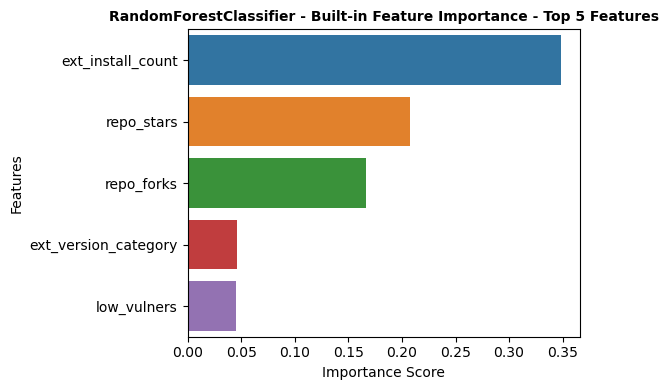

Training Gradient Boosting...


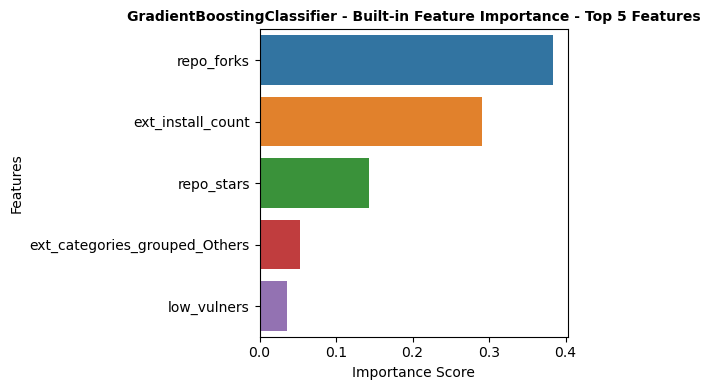

Training Ada Boost...


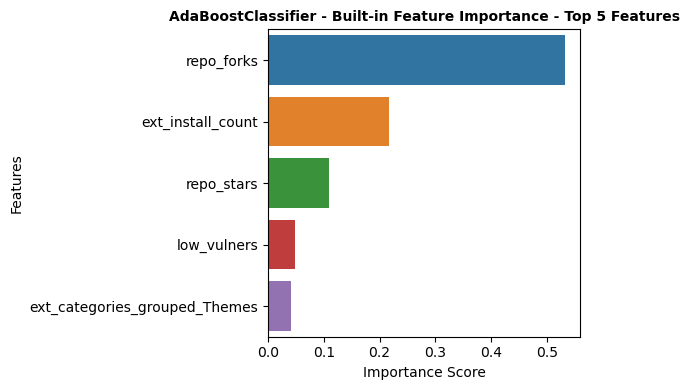

Training Extra Trees...


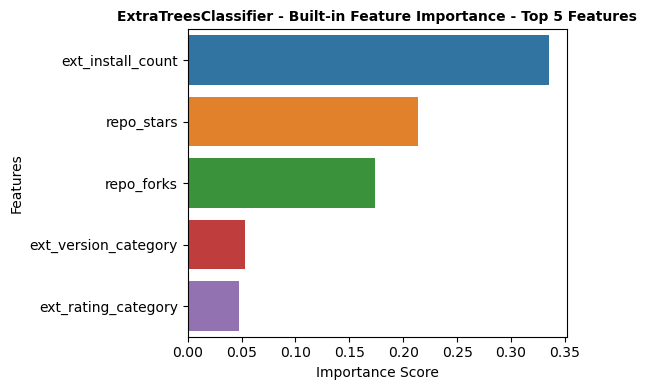

Training Decision Trees...


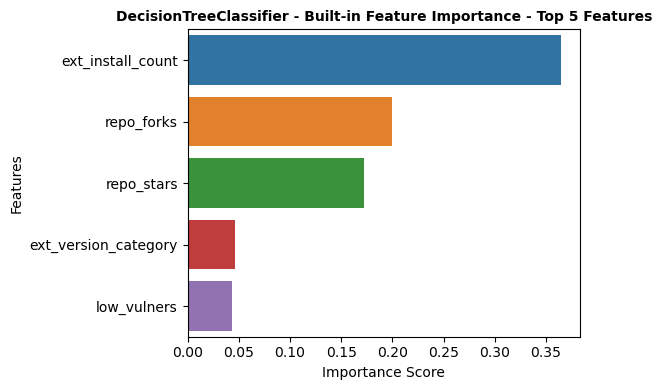

Training XGBoost...


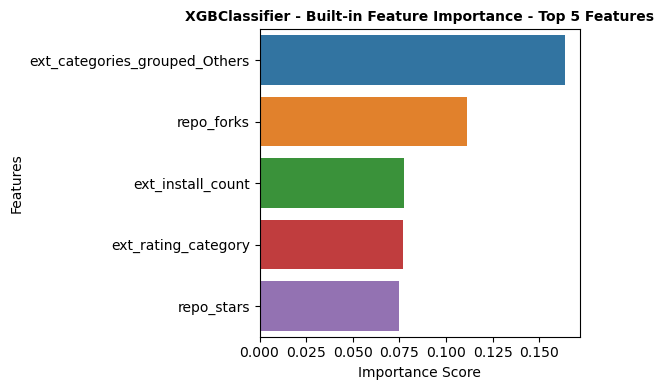

Training LightGBM...


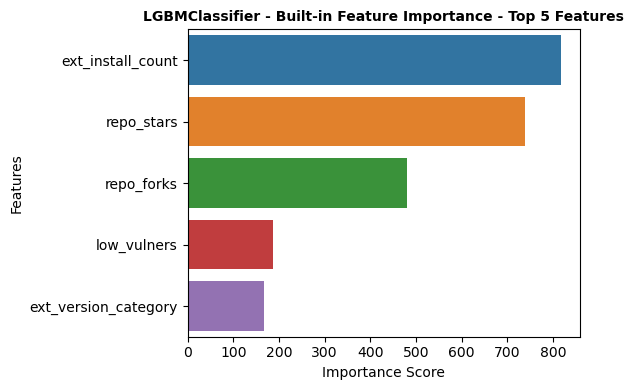

Training CatBoost...


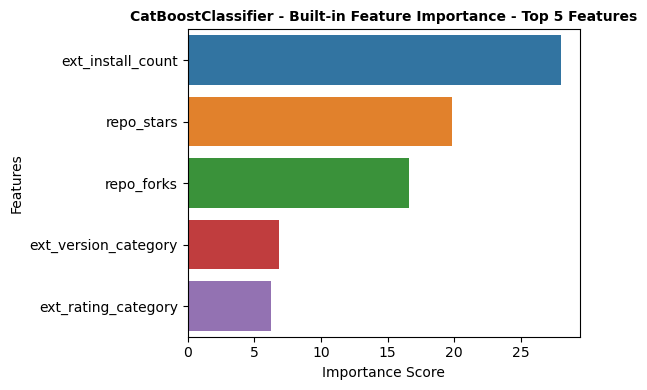

Training Logistic Regression...


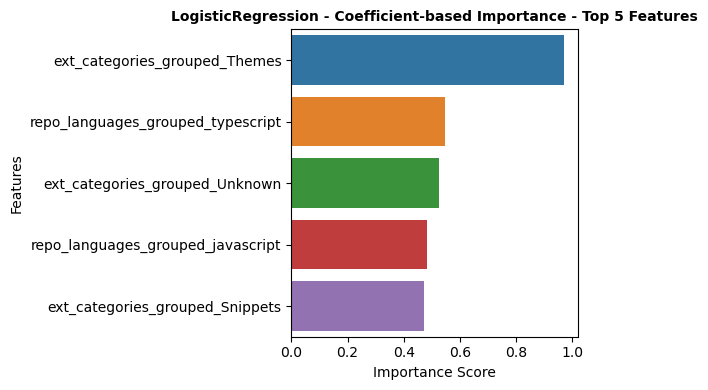

Training KNN...


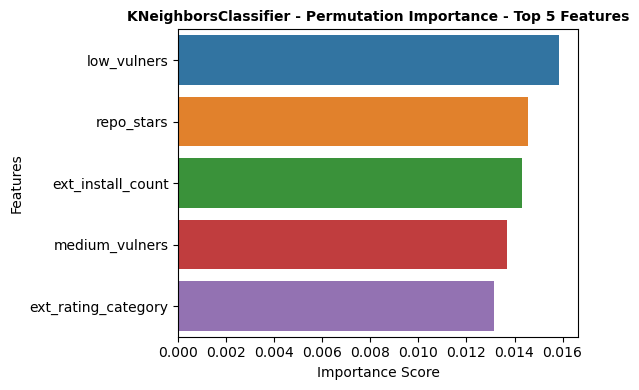


OVERALL RESULTS SUMMARY
                     Accuracy  Precision  Recall  F1_Score  ROC_AUC
Decision Trees          94.04      70.86   74.55     72.66    86.01
Random Forest           94.68      87.12   58.52     70.02    90.66
XGBoost                 94.80      91.51   56.23     69.66    90.64
Extra Trees             92.99      72.74   54.33     62.20    86.40
CatBoost                94.49      93.95   51.40     66.45    89.39
LightGBM                93.59      90.84   44.15     59.42    88.84
KNN                     90.64      60.50   34.10     43.61    77.95
Gradient Boosting       91.72      81.68   28.37     42.12    80.89
Logistic Regression     89.88      72.29    7.63     13.81    76.61
Ada Boost               89.84      86.96    5.09      9.62    77.59

INDIVIDUAL METRICS


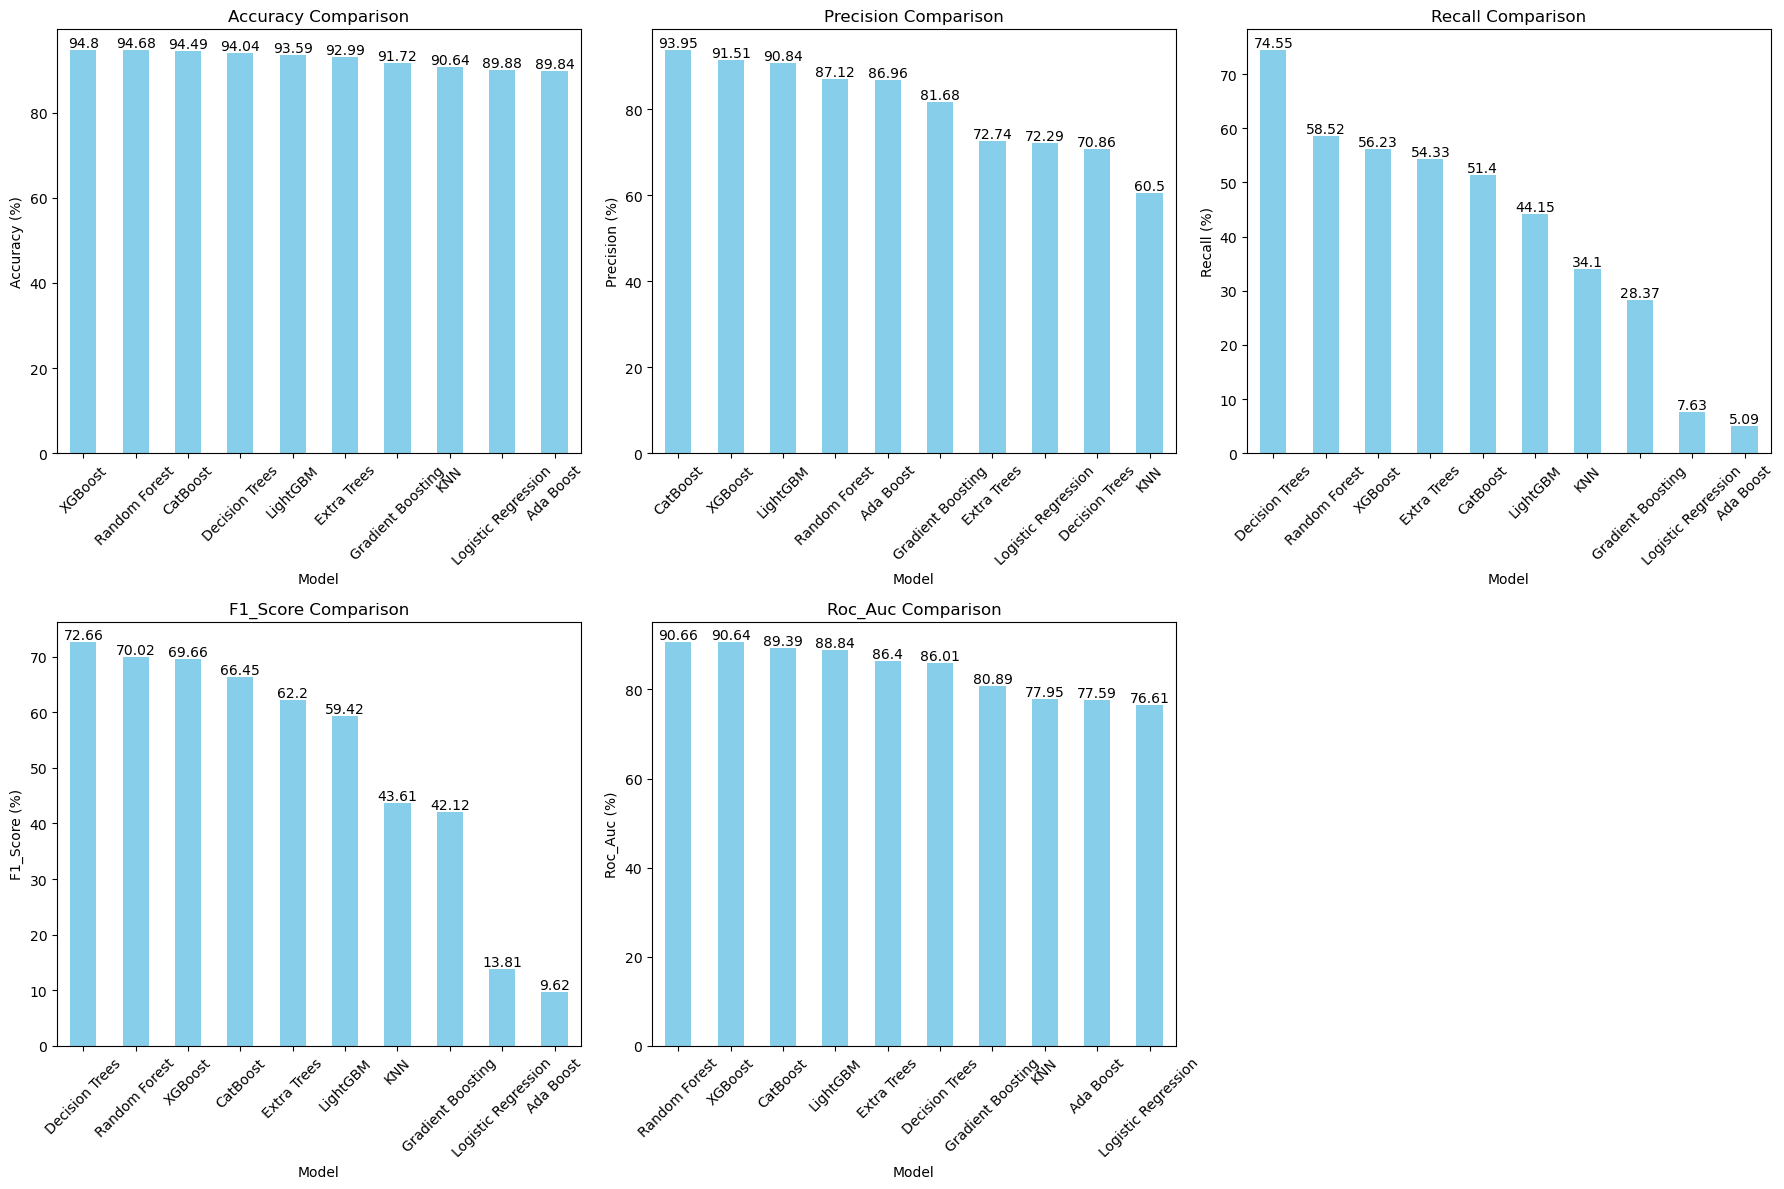


CONFUSION MATRICES OF 'RECALL'


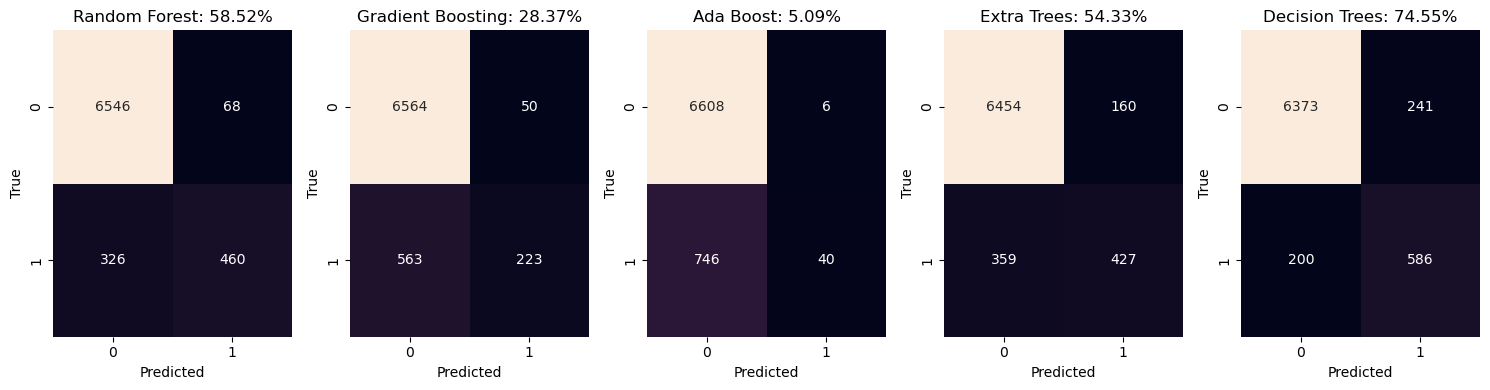

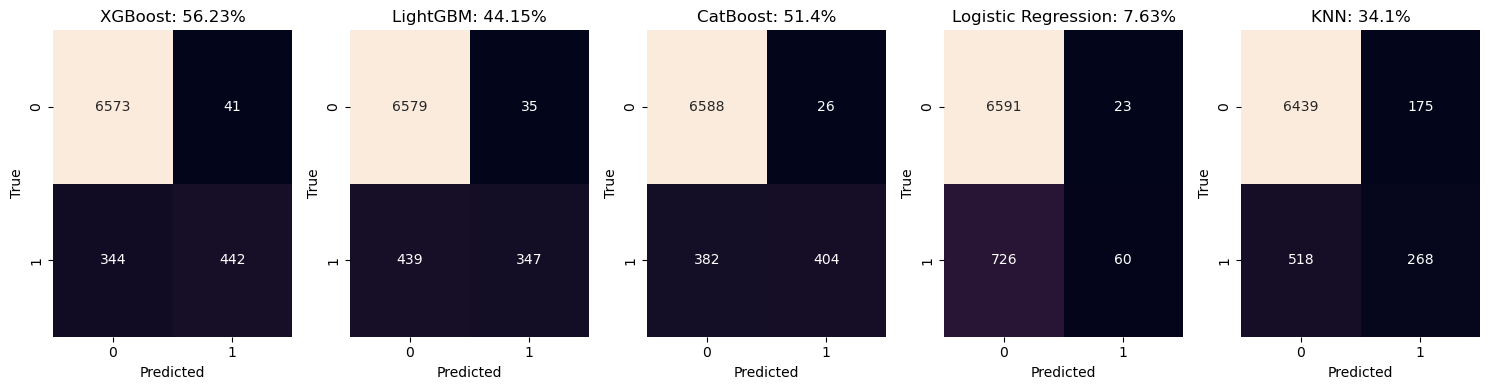


CLASSIFICATION REPORTS

******************************
Decision Trees
******************************
              precision  recall  f1-score  support
0                  0.97    0.96      0.97  6614.00
1                  0.71    0.75      0.73   786.00
accuracy           0.94    0.94      0.94     0.94
macro avg          0.84    0.85      0.85  7400.00
weighted avg       0.94    0.94      0.94  7400.00

******************************
Random Forest
******************************
              precision  recall  f1-score  support
0                  0.95    0.99      0.97  6614.00
1                  0.87    0.59      0.70   786.00
accuracy           0.95    0.95      0.95     0.95
macro avg          0.91    0.79      0.84  7400.00
weighted avg       0.94    0.95      0.94  7400.00

******************************
XGBoost
******************************
              precision  recall  f1-score  support
0                  0.95    0.99      0.97  6614.00
1                  0.92    0.56     

In [174]:
training_classification_optimized(X_train_trans, X_test_trans, y_train, y_test)

Training models...
Training Random Forest...


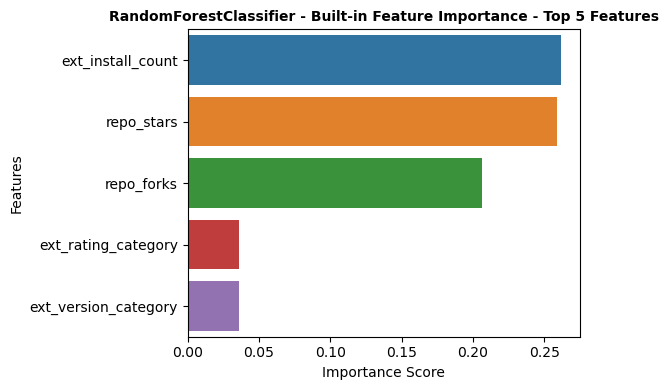

Training Gradient Boosting...


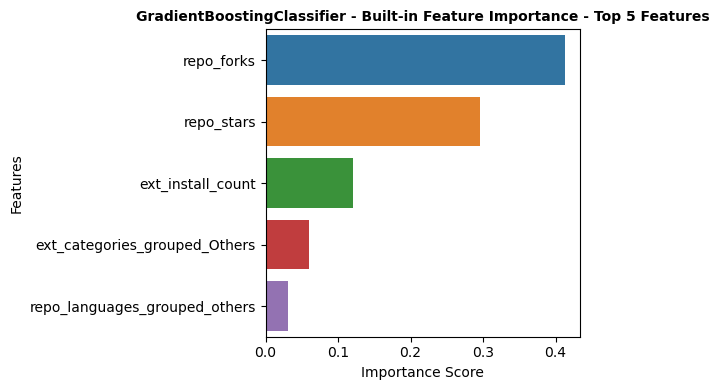

Training Ada Boost...


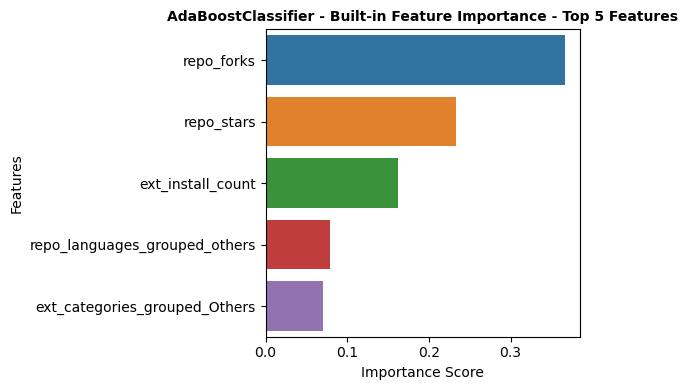

Training Extra Trees...


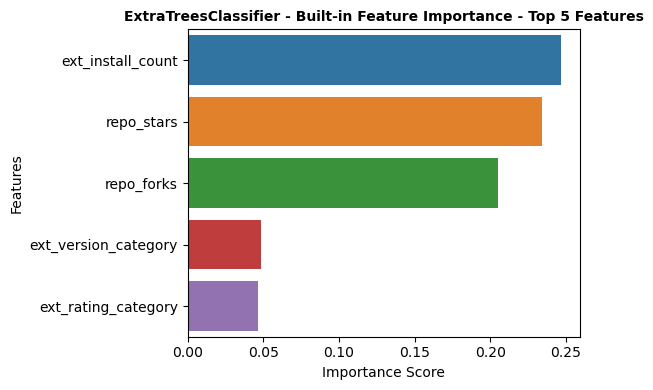

Training Decision Trees...


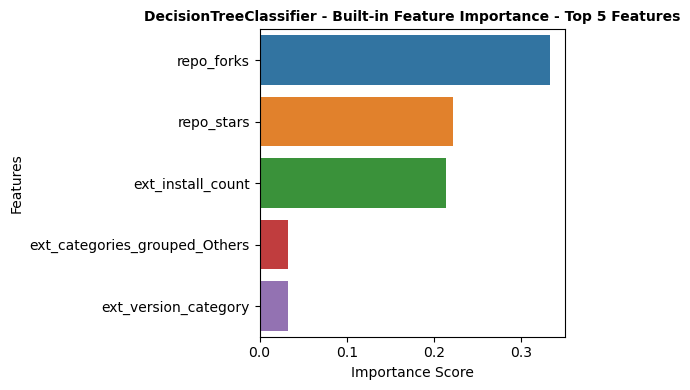

Training XGBoost...


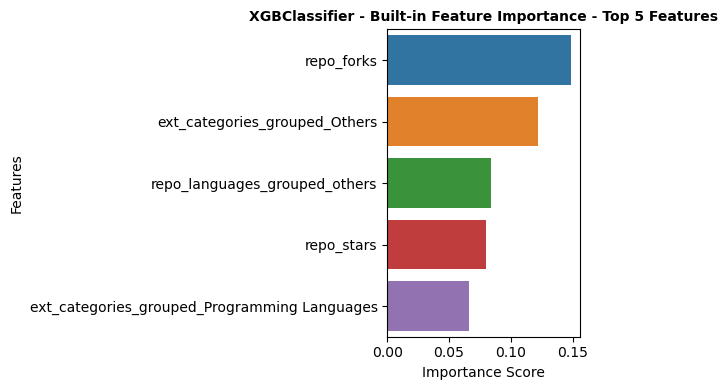

Training LightGBM...


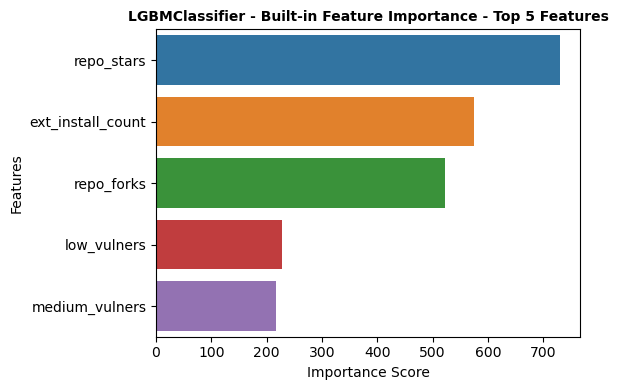

Training CatBoost...


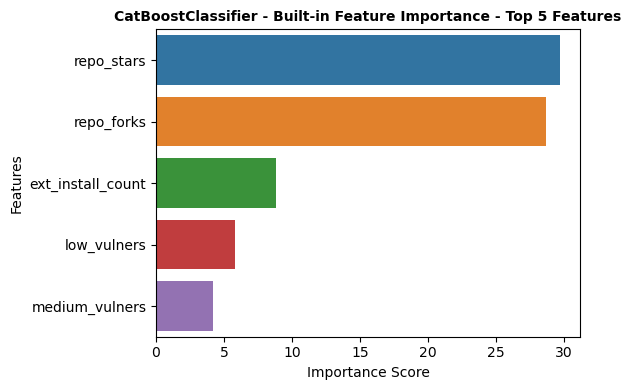

Training Logistic Regression...


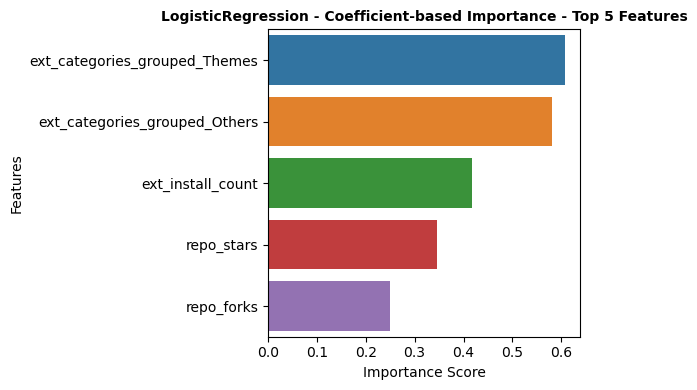

Training KNN...


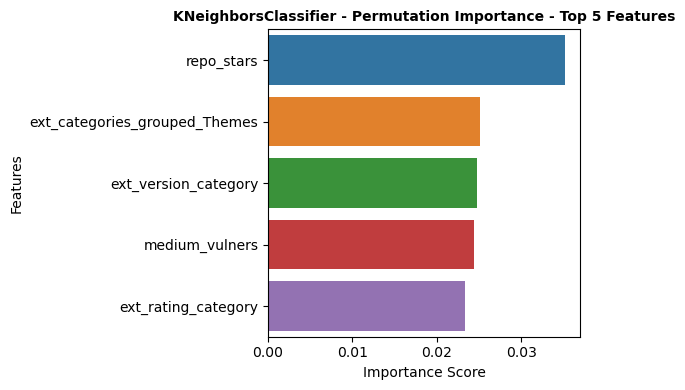


OVERALL RESULTS SUMMARY
                     Accuracy  Precision  Recall  F1_Score  ROC_AUC
Decision Trees          90.49      54.00   70.48     61.15    81.74
Logistic Regression     70.86      22.11   69.08     33.50    76.44
Ada Boost               71.51      22.48   68.70     33.88    77.15
XGBoost                 91.66      59.72   66.03     62.72    88.76
KNN                     81.01      31.07   64.63     41.97    78.54
Random Forest           90.88      56.31   62.98     59.46    88.35
CatBoost                92.84      67.93   61.70     64.67    87.78
LightGBM                88.58      47.11   61.07     53.19    84.84
Extra Trees             89.05      48.76   60.05     53.82    85.44
Gradient Boosting       81.78      31.27   59.67     41.03    80.06

INDIVIDUAL METRICS


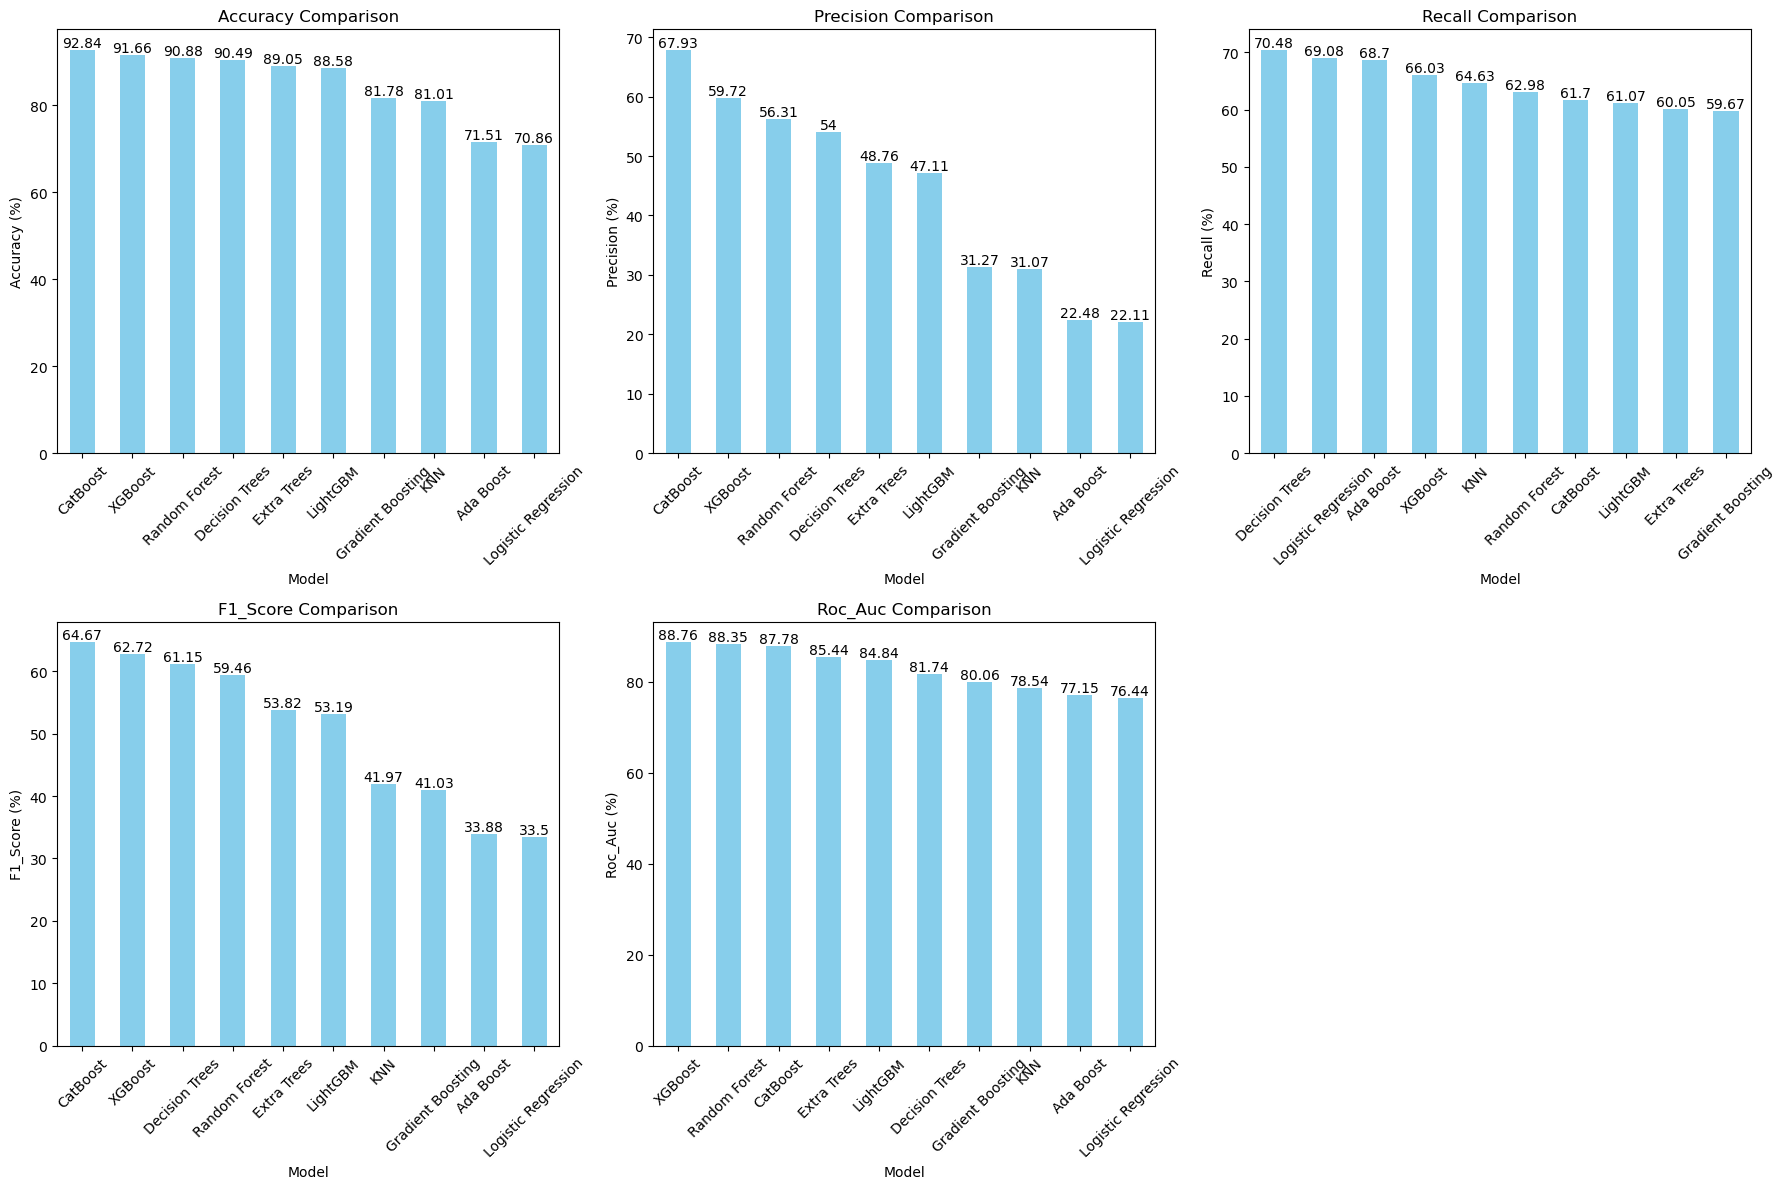


CONFUSION MATRICES OF 'RECALL'


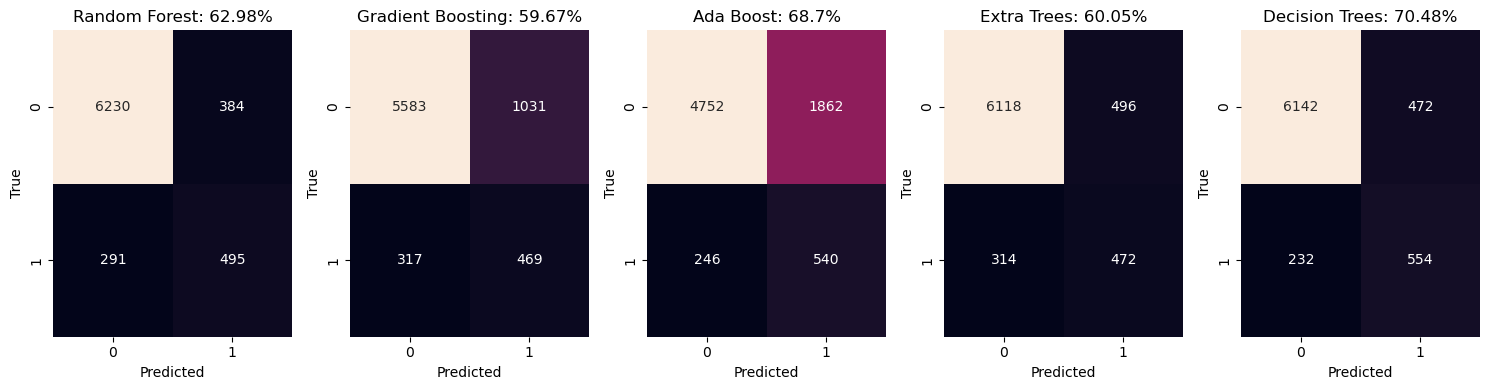

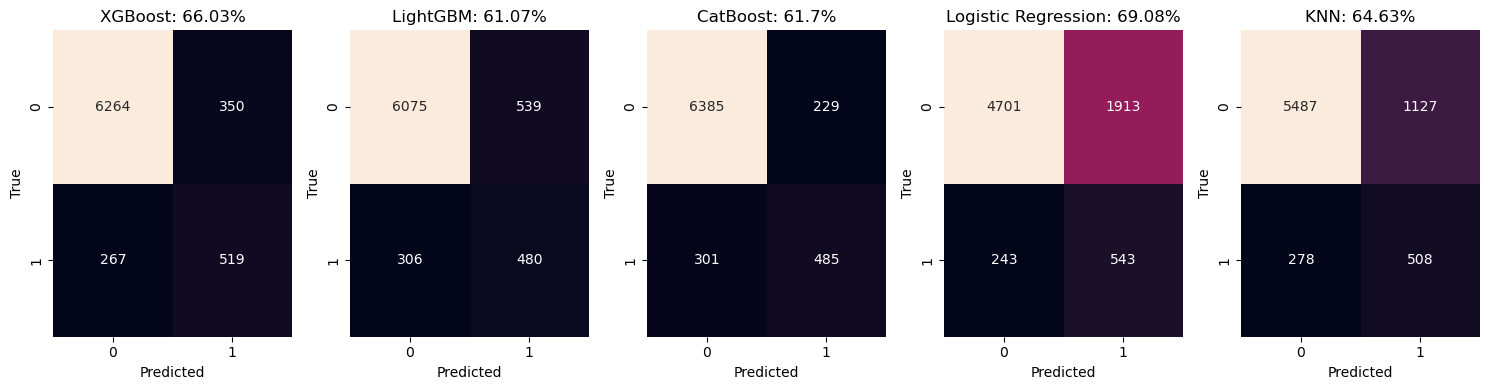


CLASSIFICATION REPORTS

******************************
Decision Trees
******************************
              precision  recall  f1-score  support
0                  0.96    0.93      0.95   6614.0
1                  0.54    0.70      0.61    786.0
accuracy           0.90    0.90      0.90      0.9
macro avg          0.75    0.82      0.78   7400.0
weighted avg       0.92    0.90      0.91   7400.0

******************************
Logistic Regression
******************************
              precision  recall  f1-score  support
0                  0.95    0.71      0.81  6614.00
1                  0.22    0.69      0.33   786.00
accuracy           0.71    0.71      0.71     0.71
macro avg          0.59    0.70      0.57  7400.00
weighted avg       0.87    0.71      0.76  7400.00

******************************
Ada Boost
******************************
              precision  recall  f1-score  support
0                  0.95    0.72      0.82  6614.00
1                  0.22    0

In [175]:
training_classification_optimized(X_train_smote, X_test_trans, y_train_smote, y_test)

In [176]:
# def plot_histograms_(df, target='diagnosis', exclude_cols=None, bins=30, cols_per_row=3):
#     if exclude_cols is None:
#         exclude_cols = []

#     # Select only numerical columns except the target and excluded ones
#     num_cols = df.select_dtypes(include='number').columns.difference(exclude_cols + [target])
#     n = len(num_cols)
#     nrows = (n + cols_per_row - 1) // cols_per_row

#     fig, axes = plt.subplots(nrows, cols_per_row, figsize=(6 * cols_per_row, 4 * nrows))
#     axes = axes.flatten()


- 🌲 Random Forest

Ensemble of decision trees (bagging).
Uses random subsets of data and features.
Robust to overfitting and outliers.
Good baseline model for tabular data.
- ⚡ AdaBoost

Sequential boosting of weak learners.
Focuses on previous misclassified samples.
Sensitive to noise/outliers.
Good for clean data with subtle patterns.
- 🚀 XGBoost

Optimized gradient boosting algorithm.
Fast, accurate, and regularized.
Best for performance with tuning effort.

- 📊 Logistic Regression

Linear model for binary classification.
Estimates probabilities using a sigmoid function.
Assumes a linear relationship between features and the log-odds of the target.
Simple, fast, and interpretable — great baseline for linearly separable data.

- 🎯 Support Vector Machine (SVM)

Finds the optimal hyperplane that maximizes the margin between classes.
Works well in high-dimensional spaces.
Can use different kernels (linear, RBF, polynomial) to capture nonlinear patterns.
Sensitive to scaling; may be slower on large datasets.

- 👟 K-Nearest Neighbors (KNN)

Instance-based learning — no training, just storing.
Classifies based on the majority label among k-nearest neighbors.
Simple and intuitive, but slow with large datasets.
Sensitive to feature scaling and irrelevant features.